In [1]:
from fredapi import Fred
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import time
import requests

In [2]:
df_root = pd.read_csv('ALL_DATA.csv', header=0)
df_root['Date'] = pd.to_datetime(df_root['Date'])  # Ensures proper datetime format
df_root.set_index('Date', inplace=True)      # Now 'Date' becomes the index

In [43]:
df_root

,CPI,INDPRO,UNRATE,FEDFUNDS,M2,PMI,US_CLI,CN_CLI
Date,,,,,,,,
1992-04-30,139.400,62.9199,7.4,3.73,3399.7,52.6,99.66689,101.87700
1992-05-31,139.700,63.1268,7.6,3.82,3398.6,55.7,99.69571,102.15670
1992-06-30,140.100,63.1624,7.8,3.76,3393.4,53.6,99.68433,102.38810
1992-07-31,140.500,63.7348,7.7,3.25,3393.9,53.9,99.67353,102.56670
1992-08-31,140.800,63.3802,7.6,3.30,3398.8,53.4,99.70633,102.69500
...,...,...,...,...,...,...,...,...
2024-12-31,317.603,103.0723,4.1,4.48,21441.8,49.3,100.49890,99.95129
2025-01-31,319.086,103.2131,4.0,4.33,21520.0,50.9,100.48120,100.12170
2025-02-28,319.775,104.1490,4.1,4.33,21613.8,50.3,100.41270,100.24210


In [44]:
from pandas import date_range, Period
from collections import defaultdict

last_full_year = df_root.index.year.max() - 1

monthly_counts = (
    df_root.index.to_period("M")
    .to_series()
    .groupby(lambda x: x.year)
    .nunique()
)

monthly_counts = monthly_counts[monthly_counts.index <= last_full_year]
expected = pd.date_range(start=df_root.index.min(), end=f"{last_full_year}-12-31", freq='M').to_period('M')
actual = df_root.index.to_period('M')
missing = sorted(set(expected) - set(actual))
missing_by_year = defaultdict(list)
if missing:
    print("MISSING DATA:")
else:
    print("DATA IS CLEAN!")
for period in missing:
    missing_by_year[period.year].append(str(period))

for year, months in missing_by_year.items():
    print(f"{year}: Missing months -> {months}")


DATA IS CLEAN!


In [45]:
df = df_root.copy()

## 2. Regime Benchmark (MSCI)

In [46]:
df['Growth_US'] = (df['US_CLI'] / df['US_CLI'].shift(12)) - (df['US_CLI'].shift(3) / df['US_CLI'].shift(15))
df['Growth_CN'] = (df['CN_CLI'] / df['CN_CLI'].shift(12)) - (df['CN_CLI'].shift(3) / df['CN_CLI'].shift(15))
df['Inflation_US'] = (df['CPI'] / df['CPI'].shift(12)) - (df['CPI'].shift(3) / df['CPI'].shift(15))

In [47]:
conditions = [
    (df['Growth_US'] <= 0) & (df['Growth_CN'] <= 0) & (df['Inflation_US'] > 0),    # Stagflation
    ((df['Growth_US'] > 0) | (df['Growth_CN'] > 0)) & (df['Inflation_US'] > 0),   # Heating Up
    (df['Growth_US'] <= 0) & (df['Growth_CN'] <= 0) & (df['Inflation_US'] <= 0),  # Slow Growth
    ((df['Growth_US'] > 0) | (df['Growth_CN'] > 0)) & (df['Inflation_US'] <= 0)   # Goldilocks
]
labels = ['Stagflation', 'Heating Up', 'Slow Growth', 'Goldilocks']
df['Regime'] = np.select(conditions, labels, default=np.nan)

In [48]:
df.dropna(inplace=True)

In [49]:
df

,CPI,INDPRO,UNRATE,FEDFUNDS,M2,PMI,US_CLI,CN_CLI,Growth_US,Growth_CN,Inflation_US,Regime
Date,,,,,,,,,,,,
1993-07-31,144.500,65.1142,6.9,3.06,3442.0,50.2,99.56270,101.02190,-0.001944,-0.017328,-0.003094,Slow Growth
1993-08-31,144.800,65.0421,6.8,3.03,3445.7,50.7,99.66826,100.68640,0.000385,-0.015959,-0.003803,Goldilocks
1993-09-30,145.000,65.3749,6.7,3.09,3452.2,50.8,99.85506,100.44470,0.001849,-0.013167,-0.002339,Goldilocks
1993-10-31,145.600,65.8630,6.8,2.99,3456.7,53.4,100.09220,100.31550,0.002511,-0.009197,-0.000947,Goldilocks
1993-11-30,146.000,66.1696,6.6,3.02,3470.1,53.8,100.35460,100.29030,0.003096,-0.004825,-0.000964,Goldilocks
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31,317.603,103.0723,4.1,4.48,21441.8,49.3,100.49890,99.95129,0.000176,0.014864,0.004398,Heating Up
2025-01-31,319.086,103.2131,4.0,4.33,21520.0,50.9,100.48120,100.12170,-0.002261,0.015833,0.004280,Heating Up
2025-02-28,319.775,104.1490,4.1,4.33,21613.8,50.3,100.41270,100.24210,-0.004248,0.015497,0.001001,Heating Up


## 3. Feature Engineering

In [54]:
df["CPI_YoY"] = df["CPI"].pct_change(12)
df["INDPRO_3M_Change"] = df["INDPRO"].diff(3)
df["PMI_3M_Change"] = df["PMI"].diff(3)
df["M2_YoY"] = df["M2"].pct_change(12)

df["CPI_YoY_3M_Avg"] = (1/3) * (df["CPI_YoY"].shift(periods=1) + df["CPI_YoY"].shift(periods=2) + df["CPI_YoY"].shift(periods=3))
df["CPI_YoY_MA"] = df.rolling(3*12)['CPI_YoY'].mean()
df['Inflation_Z'] = df["CPI_YoY_3M_Avg"] - df["CPI_YoY_MA"]

window = 12
for col in ["CN_CLI", "CPI_YoY", "INDPRO_3M_Change", "UNRATE", "FEDFUNDS", "M2_YoY", "PMI_3M_Change", "US_CLI"]:
    roll = df[col].rolling(window, closed="left")
    mean_col = roll.mean()
    std_col  = roll.std()
    z = (df[col] - mean_col) / std_col
    z[std_col == 0] = 0.0
    df[col + "_z"] = z

df['CPI_YoY_z_lag1'] = df['CPI_YoY_z'].shift(1)
df['US_CLI_z_lag1'] = df['US_CLI_z'].shift(1)
df['CN_CLI_z_lag1'] = df['CN_CLI_z'].shift(1)

features = df[[
    # "PMI_3M_Change_z",
    # "UNRATE_z",
    # "INDPRO_3M_Change_z",
    "FEDFUNDS_z",
    "M2_YoY_z",
    "Inflation_Z",
    "CPI_YoY_z_lag1",
    "US_CLI_z_lag1",
    "CN_CLI_z_lag1",

]]

target1 = df["Regime"]
df_model = features.copy()
df_model["Regime"] = target1
df_model.dropna(inplace=True)

X_full = df_model.drop("Regime", axis=1).values
y_full = df_model["Regime"].values
dates  = df_model.index

In [55]:
df_model

,FEDFUNDS_z,M2_YoY_z,Inflation_Z,CPI_YoY_z_lag1,US_CLI_z_lag1,CN_CLI_z_lag1,Regime
Date,,,,,,,
1997-06-30,2.256793,0.519494,-0.003270,-2.877188,2.123332,-3.143799,Slow Growth
1997-07-31,1.400624,0.726507,-0.004895,-2.073424,2.016847,-2.726951,Goldilocks
1997-08-31,1.378844,2.832227,-0.005621,-1.828818,1.843218,-2.406099,Heating Up
1997-09-30,1.159362,2.501073,-0.005239,-1.180179,1.655740,-2.138586,Slow Growth
1997-10-31,0.693593,1.940241,-0.005141,-1.179285,1.464088,-1.909012,Slow Growth
...,...,...,...,...,...,...,...
2024-12-31,-3.130260,1.372956,-0.024609,-0.939464,2.231571,0.063852,Heating Up
2025-01-31,-2.607224,1.225382,-0.021872,-0.347668,1.993515,0.665336,Heating Up
2025-02-28,-1.905875,1.127080,-0.019018,0.139347,1.595563,1.369951,Heating Up


In [56]:
df_model['Regime'].value_counts()

Goldilocks     120
Heating Up     109
Stagflation     58
Slow Growth     48
Name: Regime, dtype: int64

## 4. SVM w Walk-Forward Validation

In [57]:
first_test_date = pd.Timestamp("2016-01-31")
results = []

for i, current_date in enumerate(dates):
    if current_date < first_test_date:
        continue

    train_mask = dates < current_date
    test_mask  = dates == current_date

    X_train, y_train = X_full[train_mask], y_full[train_mask]
    X_test,  y_test  = X_full[test_mask],  y_full[test_mask]

    # skip if y_test is empty
    if y_test.size == 0:
        continue

    # pipeline = scaler + SVM
    pipe = make_pipeline(
        StandardScaler(),
        SVC(kernel="rbf",
            class_weight="balanced",
            probability=False,
            random_state=0)
    )

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    results.append({
        "Date"      : current_date,
        "TrueLabel" : y_test[0],
        "PredLabel" : y_pred[0],
        "Acc"       : acc
    })

cv_df = pd.DataFrame(results).set_index("Date")
overall_acc = cv_df["Acc"].mean()

print(f"\n--- SVM Performance Against MSCI Fallback Benchmark ---")
print(f"\nWalk-forward overall accuracy: {overall_acc:.3f}")
print(cv_df["Acc"].value_counts(normalize=True).rename("frequency"))

# Confusion matrix over all steps, using the new benchmark labels
cm = confusion_matrix(cv_df["TrueLabel"], cv_df["PredLabel"],
                      labels=labels) # uses labels: ['Stagflation', 'Heating Up', 'Slow Growth', 'Goldilocks']

print("\nConfusion Matrix (expanding window vs. Benchmark):\n")
cm_df = pd.DataFrame(cm, index=[f"True_{l}" for l in labels], columns=[f"Pred_{l}" for l in labels])
display(cm_df)


--- SVM Performance Against MSCI Fallback Benchmark ---

Walk-forward overall accuracy: 0.634
1.0    0.633929
0.0    0.366071
Name: frequency, dtype: float64

Confusion Matrix (expanding window vs. Benchmark):



,Pred_Stagflation,Pred_Heating Up,Pred_Slow Growth,Pred_Goldilocks
True_Stagflation,13,2,0,2
True_Heating Up,7,23,4,11
True_Slow Growth,1,2,6,0
True_Goldilocks,3,7,2,29


## 5. Output Visualization

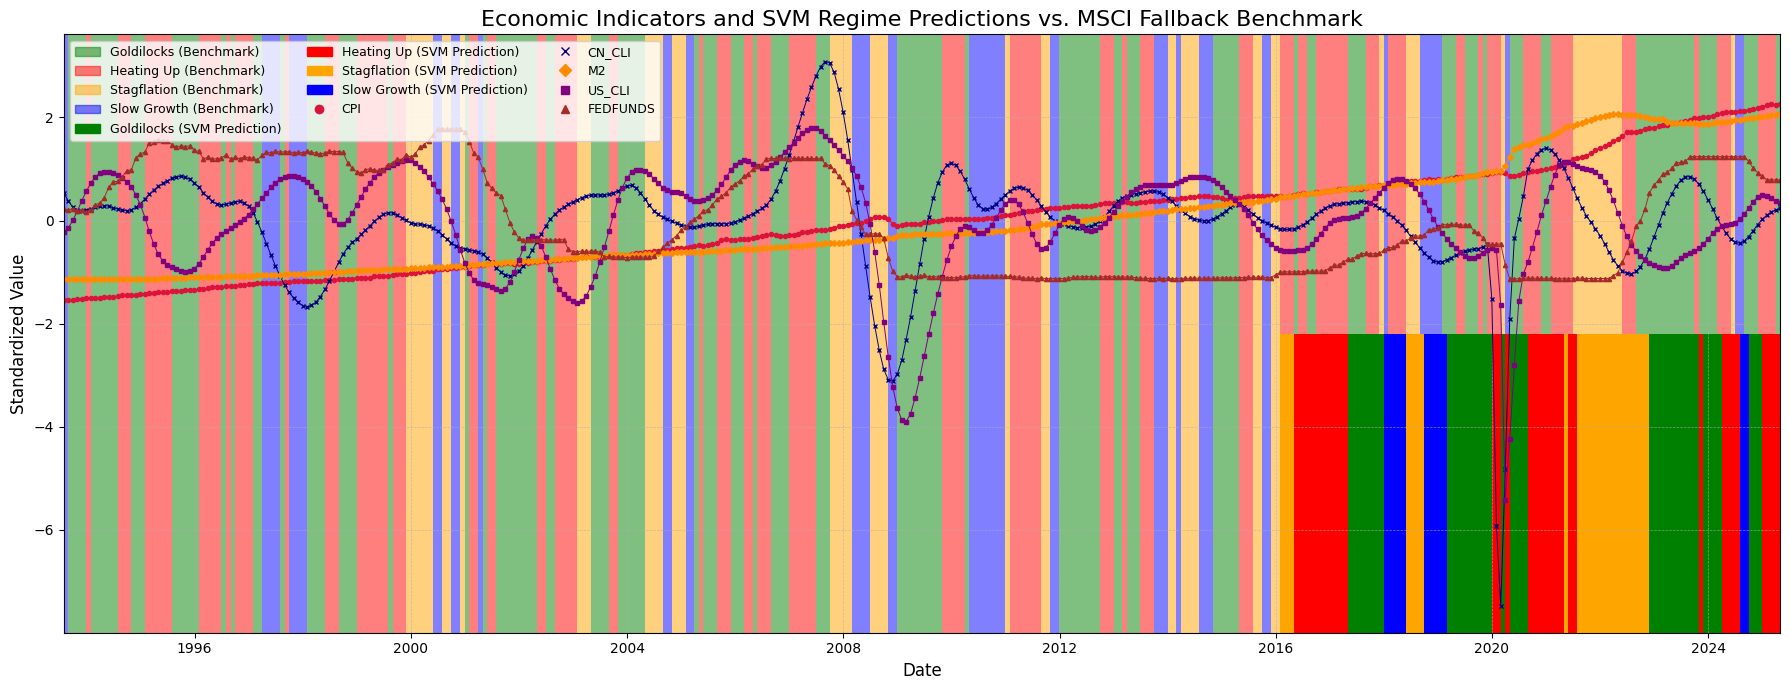

In [63]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn.preprocessing import StandardScaler

# This script assumes that 'df_root', 'df', and 'cv_df' are available in your
# environment from the execution of the main script that uses the MSCI Fallback Benchmark.

# ------------------------------------------------------
# 1.  Prepare a plotting DataFrame with scaled factors
# ------------------------------------------------------
# This part remains unchanged as it correctly prepares the data for plotting.
plot_cols = ["CPI", "CN_CLI", "M2", "US_CLI", "FEDFUNDS"]
scaler_vis  = StandardScaler()
# Use a slice of df_root that aligns with df_plot to avoid scaling issues on data not used.
plot_data_source = df_root.loc[df.index, plot_cols].dropna()
scaled_vals = scaler_vis.fit_transform(plot_data_source)
df_plot = pd.DataFrame(scaled_vals, index=plot_data_source.index, columns=plot_cols)

# ------------------------------------------------------
# 2.  Colour maps & transparency
# ------------------------------------------------------
# --- MODIFIED SECTION ---
# The colour map is updated to match the final MSCI Fallback regime labels.
# Colors are chosen to be intuitive: Red for hot, Orange for troubled, Blue for slow, Green for good.
colour_map = {
    "Goldilocks"  : "green",
    "Heating Up"  : "red",
    "Stagflation" : "orange",
    "Slow Growth" : "blue"
}

# User-defined transparency and shading region
benchmark_alpha  = 0.5  # Made it slightly more transparent to see lines better
prediction_alpha = 1  # Made it slightly more transparent to see lines better
prediction_ymin  = 0
prediction_ymax  = 0.5

# ------------------------------------------------------
# 3.  Build a Series with predicted labels indexed by date
# ------------------------------------------------------
# This part remains unchanged.
pred_s = cv_df["PredLabel"]

# ------------------------------------------------------
# 4.  Plot
# ------------------------------------------------------
fig, ax = plt.subplots(figsize=(18, 7)) # Made plot slightly taller

# 4-A  Shaded benchmark regimes (full height)
# This loop correctly uses the new 'Regime' column from the main script.
for i in range(len(df.index)-1):
    # Ensure we only plot for the date range we have indicators for
    current_date = df.index[i]
    if current_date not in df_plot.index:
        continue
    cls = df.loc[current_date, "Regime"]
    if cls not in colour_map:
        continue
    ax.axvspan(df.index[i], df.index[i+1],
               color=colour_map[cls], alpha=benchmark_alpha, lw=0)

# 4-B  Shaded SVM predictions (top half only, test window onward)
# This loop correctly uses the prediction series and the updated colour map.
for i in range(len(pred_s)-1):
    cls = pred_s.iloc[i]
    dt0, dt1 = pred_s.index[i], pred_s.index[i+1]
    ax.axvspan(dt0, dt1,
               ymin=prediction_ymin, ymax=prediction_ymax,
               color=colour_map.get(cls, 'grey'), # Use .get() for safety if a label is unexpected
               alpha=prediction_alpha, lw=0)

# 4-C  Scatter / line plots of the indicators
# This part remains unchanged.
markers = dict(zip(plot_cols, ["o", "x", "D", "s", "^"]))

indicator_colors = {
    "CPI"      : "crimson",
    "CN_CLI"   : "navy",
    "M2"       : "darkorange",
    "US_CLI"   : "purple",
    "FEDFUNDS" : "brown"
}

for col in plot_cols:
    ax.plot(df_plot.index, df_plot[col],
            marker=markers[col], markersize=3,
            linewidth=0.7, label=col,
            color=indicator_colors[col])

# 4-D  Build composite legend
# This section is updated to use the new colour map and cleaned up to remove duplication.
handles = [Patch(color=c, alpha=benchmark_alpha, label=f"{regime} (Benchmark)")
           for regime, c in colour_map.items()]
handles += [Patch(color=c, alpha=prediction_alpha,
                  label=f"{regime} (SVM Prediction)")
            for regime, c in colour_map.items()]

for col in plot_cols:
    h, = ax.plot([], [], marker=markers[col], ls="",
                 color=indicator_colors[col],
                 label=col)
    handles.append(h)

ax.legend(handles=handles, loc="upper left", ncol=3, fontsize=9)

# Final plot adjustments
ax.set_title("Economic Indicators and SVM Regime Predictions vs. MSCI Fallback Benchmark", fontsize=16)
ax.set_ylabel("Standardized Value", fontsize=12)
ax.set_xlabel("Date", fontsize=12)
ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)
ax.set_xlim(df_plot.index.min(), df_plot.index.max()) # Ensure x-axis is tidy
plt.tight_layout()
plt.show()